In [124]:
import numpy as np
from keras.models import load_model
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [125]:
# Hagan's SABR formula (simplified)
def SABR(alpha, beta, nu, rho, F, K, T):

    eps_SABR = 0.0001
    
    V = (F * K)**((1.0 - beta) / 2.0)
    logFK = np.log(F / K)
    
    tmp1 = nu * nu * (2.0 - 3.0 * rho * rho) / 24.0
    tmp1 += rho * beta * nu * alpha / (V * 4.0)
    tmp1 += (1.0 - beta) * (1.0 - beta) * alpha * alpha / ((V**2) * 24.0)
    tmp1 = alpha * (1.0 + (tmp1 * T))
    
    tmp2 = V * (1.0 + np.power(logFK * (1.0 - beta), 2.0) / 24.0 + np.power(logFK * (1.0 - beta), 4.0) / 1920.0)
    
    z = nu / alpha  * V * logFK
    
    def chi(z):
        
        eps_SABR = 0.0001
        
        tmp1 = np.sqrt(1.0 - 2.0 * rho * z + z * z)
        np.where(abs(z) < eps_SABR, z, z)
        
        z = np.where((tmp1 + z - rho > 0.0),
                     np.log((tmp1 + z - rho) / (1.0 - rho)), np.log((1.0 + rho) / (tmp1 - (z - rho))))
        
        return z
    
    chi_z = chi(z)
    
    vol = np.where(abs(F - K) > eps_SABR, tmp1 / tmp2 * z / chi_z, tmp1 / np.power(F, 1.0 - beta))
    
    return vol        

In [126]:
def PlotSmile(K, smile_cf, smile_nn, alpha, beta, nu, rho, f, T, rmse):
    plt.title('T=%.2f' % T + ', F=%.2f' %(f*100) + ', alpha=%.2f' %(alpha * 100) + ', beta=%.2f' %beta + ',\n' +
              'nu=%.2f' %(nu*100) + ', rho=%.2f' %(rho * 100) + ', rmse=%.1f' %rmse +'bps')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.plot(K, smile_cf, color='blue', label='Closed-Form')
    plt.plot(K, smile_nn, color='red', label='NN')
    plt.legend(loc = 'upper right')

In [127]:
def CheckSmile(sigma, beta, nu, rho, f, T):
    alpha = sigma / f**(beta - 1.0)
    smile_cf = SABR(alpha, beta, nu, rho, f, K, T)
    testPoints = np.ndarray(shape=(nPoints, 7))
    for i in range(nPoints):
        testPoints[i,0] = alpha
        testPoints[i,1] = beta
        testPoints[i,2] = nu
        testPoints[i,3] = rho
        testPoints[i,4] = f
        testPoints[i,5] = K[i]
        testPoints[i,6] = T

    scaler.transform(testPoints)
    smile_nn = trainedModel.predict(testPoints)
    rmse = np.sqrt(mean_squared_error(smile_cf, smile_nn)) * 10000
    PlotSmile(K, smile_cf, smile_nn, alpha, beta, nu, rho, f, T, rmse)       

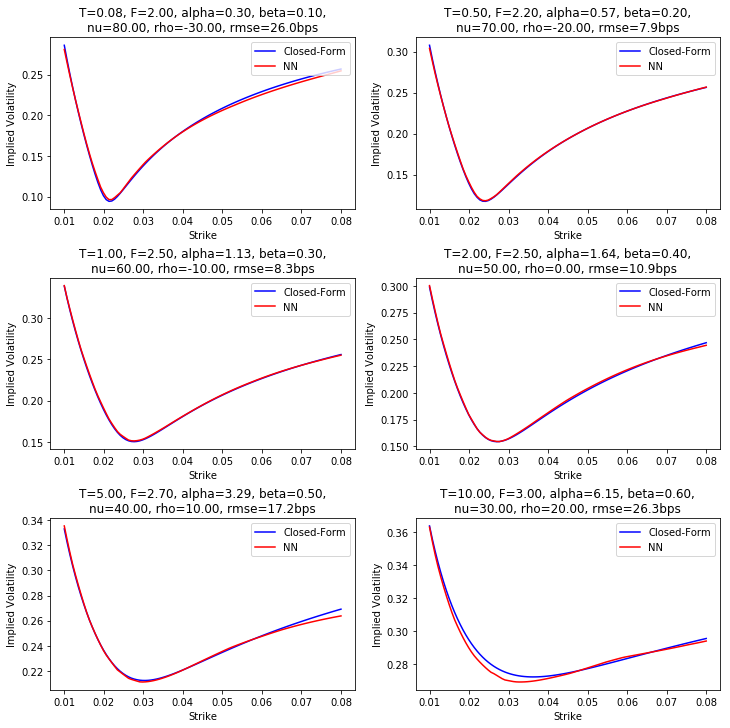

In [128]:
trainedModel = load_model('nn_SABR.h5')
scaler = joblib.load('scaler_SABR.h5')

# Pick parameters and compare closed-form vs NN
nPoints = 100
K = np.linspace(0.01, 0.08, num=nPoints)

#print('Alpha = %.2f' % (Alpha * 100))
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.40)
plt.subplot(3,2,1)
CheckSmile(0.10, 0.10, 0.80, -0.30, 0.020, 1/12)
plt.subplot(3,2,2)
CheckSmile(0.12, 0.20, 0.70, -0.20, 0.022, 0.50)
plt.subplot(3,2,3)
CheckSmile(0.15, 0.30, 0.60, -0.10, 0.025, 1)
plt.subplot(3,2,4)
CheckSmile(0.15, 0.40, 0.50, +0.00, 0.025, 2)
plt.subplot(3,2,5)
CheckSmile(0.20, 0.50, 0.40, +0.10, 0.027, 5)
plt.subplot(3,2,6)
CheckSmile(0.25, 0.60, 0.30, +0.20, 0.030, 10)